In [23]:
# Imports
from tira.third_party_integrations import ensure_pyterrier_is_loaded, persist_and_normalize_run
from tira.rest_api_client import Client
import pyterrier as pt
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

In [24]:
# Create a REST client to the TIRA platform for retrieving the pre-indexed data.
ensure_pyterrier_is_loaded()
tira = Client()

In [25]:
# The dataset: the union of the IR Anthology and the ACL Anthology
# This line creates an IRDSDataset object and registers it under the name provided as an argument.
pt_dataset = pt.get_dataset('irds:ir-lab-sose-2024/ir-acl-anthology-20240504-training')
pt_dataset.get_qrels().head(4)
ground_truth = pt_dataset.get_qrels()

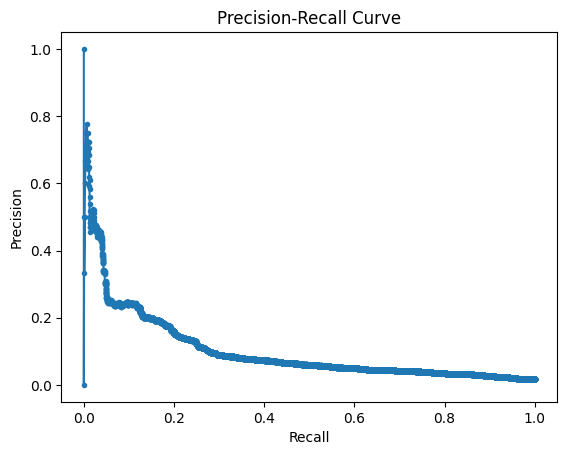

In [26]:
results_bm25 = pt.io.read_results('./runs/bm25.txt')
results_abbr = pt.io.read_results('./runs/abbrevations.txt')
results_full = pt.io.read_results('./runs/fullrun/run.txt')
results_only_ngram = pt.io.read_results('./runs/onlyngram/run.txt')



merged = results_abbr.merge(ground_truth, on=['qid', 'docno'], how='left').fillna(0)

y_true = merged['label'].astype(int)
y_scores = merged['score']

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Plot Precision-Recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

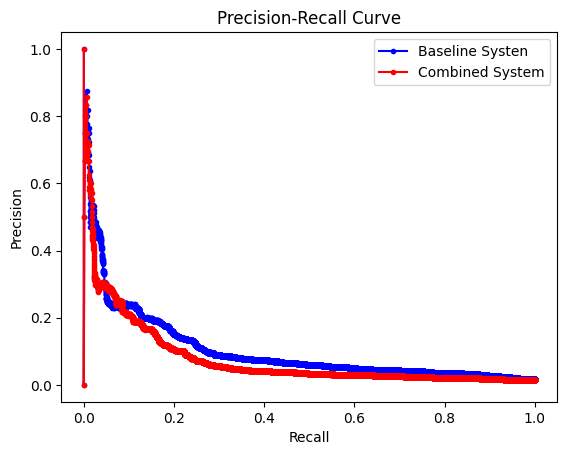

In [27]:

def plot_pr_curve(results, ground_truth, label, color):
    merged = results.merge(ground_truth, on=['qid', 'docno'], how='left').fillna(0)
    y_true = merged['label'].astype(int)
    y_scores = merged['score']

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, marker='.', label=label, color=color)  # Use color directly here

# Plot PR curve for each results set with different colors
plot_pr_curve(results_bm25, ground_truth, label='Baseline Systen', color='blue')
plot_pr_curve(results_only_ngram, ground_truth, label='Combined System', color='red')

# Customize plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

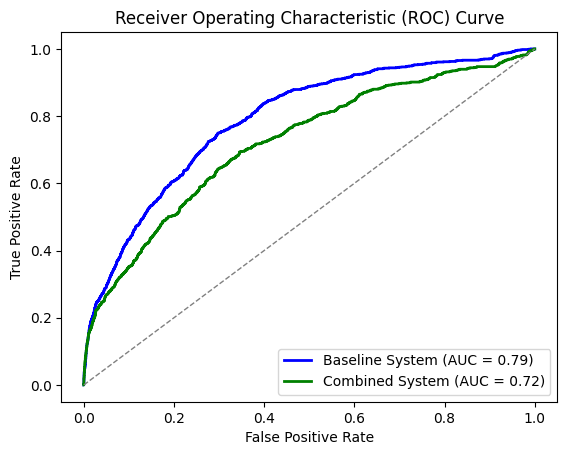

In [37]:

def plot_roc_curve(results, ground_truth, label, color):
    merged = results.merge(ground_truth, on=['qid', 'docno'], how='left').fillna(0)
    y_true = merged['label'].astype(int)
    y_scores = merged['score']

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

# Plot ROC curve for each results set with different colors
plot_roc_curve(results_bm25, ground_truth, label='Baseline System', color='blue')
plot_roc_curve(results_full, ground_truth, label='Combined System', color='green')

# Customize plot
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [29]:
# This assumes we have execited the ../baseline-retrieval-system/baseline-retrieval-system.ipynb notebook before.
bm25 = pt.io.read_results('../runs/runbm25.txt')
print(bm25.columns)
ngrams = pt.io.read_results('../runs/runngram.txt')
pt.Experiment(
    [bm25, ngrams],
    pt_dataset.get_topics(),
    pt_dataset.get_qrels(),
    ["ndcg_cut.10", "recip_rank", "recall_1000", "map"],
    names=["BM25", "Ngrams"]
)

Index(['qid', 'docno', 'rank', 'score', 'name'], dtype='object')
There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


,name,ndcg_cut.10,recip_rank,recall_1000,map
0,BM25,0.374041,0.579877,0.825376,0.262311
1,Ngrams,0.352402,0.567611,0.717923,0.226362


In [30]:
# This assumes we have execited the ../baseline-retrieval-system/baseline-retrieval-system.ipynb notebook before.
bm25 = pt.io.read_results('./runs/bm25.txt')

abbreviations = pt.io.read_results('./runs/abbrevations.txt')
#ngrams = pt.io.read_results('../runs/runngram.txt')
full = pt.io.read_results('./runs/fullrun/run.txt')
res_dict = pt.Experiment(
    [bm25, abbreviations, full],
    pt_dataset.get_topics(),
    pt_dataset.get_qrels(),
    ["ndcg_cut.10", "recip_rank", "recall_1000", "map"],
    names=["BM25","Abbr", "Full"],
    #baseline=0,
    perquery = True,
    save_dir = "./",
    save_mode="overwrite",
    dataframe = True,
)
print(res_dict)

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
     name qid      measure     value
272  Abbr   1          map  0.404455
273  Abbr   1   recip_rank  1.000000
274  Abbr   1  recall_1000  0.966667
275  Abbr   1  ndcg_cut.10  0.835780
308  Abbr  10          map  0.001188
..    ...  ..          ...       ...
575  Full   8  ndcg_cut.10  0.000000
576  Full   9          map  0.160744
577  Full   9   recip_rank  0.166667
578  Full   9  recall_1000  1.000000
579  Full   9  ndcg_cut.10  0.154481

[816 rows x 4 columns]


when looking at only abbreviations, we get better map with the nvidia cuda query, but worse map with the bm25 and what is ahp query

In [31]:
import pandas as pd
df = pd.DataFrame(res_dict)
print(df)
# Filter criteria
filter_criteria = (
    (df['measure'] == 'recall_1000') &
    (df['name'].isin(['Abbr', 'BM25']))
)

# Apply the filter
filtered_df = df[filter_criteria]

# Group by 'qid' and filter groups that have both 'NGRAMS' and 'BM25' entries
groups = filtered_df.groupby('qid')
valid_pairs = []
valid_qids = []
for qid, group in groups:
    if len(group) == 2 and set(group['name']) == {'Abbr', 'BM25'}:
        ngrams_row = group[group['name'] == 'Abbr'].iloc[0]
        bm25_row = group[group['name'] == 'BM25'].iloc[0]
        
        if ngrams_row['value'] > bm25_row['value']:
            valid_pairs.append((ngrams_row, bm25_row))
            valid_qids.append(qid)
# Print the valid pairs
for ngrams_row, bm25_row in valid_pairs:
    print(f"Pair found for qid {ngrams_row['qid']}:")
    print(f"Abbr: {ngrams_row}")
    print(f"BM25: {bm25_row}")
    print(valid_qids)


     name qid      measure     value
272  Abbr   1          map  0.404455
273  Abbr   1   recip_rank  1.000000
274  Abbr   1  recall_1000  0.966667
275  Abbr   1  ndcg_cut.10  0.835780
308  Abbr  10          map  0.001188
..    ...  ..          ...       ...
575  Full   8  ndcg_cut.10  0.000000
576  Full   9          map  0.160744
577  Full   9   recip_rank  0.166667
578  Full   9  recall_1000  1.000000
579  Full   9  ndcg_cut.10  0.154481

[816 rows x 4 columns]


In [32]:
import pandas as pd

#print(pt_dataset.get_topics())
#valid_qids_normal = ['10', '18', '20', '28', '29', '3', '31', '33', '39', '4', '49', '51', '56', '62', '65', '68']
df = pd.DataFrame(pt_dataset.get_topics())
#print(df)

filtered_df = df[df['qid'].isin(valid_qids)]
# Printing the filtered DataFrame
print(filtered_df)

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
Empty DataFrame
Columns: [qid, text, title, query, description, narrative]
Index: []


GET ALL QUERIES WHERE WE HAVE BETTER RECALL THAN BM25

In [33]:
import pandas as pd
df = pd.DataFrame(res_dict)
print(df)
# Filter criteria
filter_criteria = (
    (df['measure'] == 'map') &
    (df['name'].isin(['Full', 'BM25']))
)

# Apply the filter
filtered_df = df[filter_criteria]

# Group by 'qid' and filter groups that have both 'NGRAMS' and 'BM25' entries
groups = filtered_df.groupby('qid')
valid_pairs = []
valid_qids = []
for qid, group in groups:
    if len(group) == 2 and set(group['name']) == {'Full', 'BM25'}:
        ngrams_row = group[group['name'] == 'Full'].iloc[0]
        bm25_row = group[group['name'] == 'BM25'].iloc[0]
        
        if ngrams_row['value'] > bm25_row['value']:
            valid_pairs.append((ngrams_row, bm25_row))
            valid_qids.append(qid)
# Print the valid pairs
for ngrams_row, bm25_row in valid_pairs:
    print(f"Pair found for qid {ngrams_row['qid']}:")
    print(f"Full: {ngrams_row}")
    print(f"BM25: {bm25_row}")
    print(valid_qids)


     name qid      measure     value
272  Abbr   1          map  0.404455
273  Abbr   1   recip_rank  1.000000
274  Abbr   1  recall_1000  0.966667
275  Abbr   1  ndcg_cut.10  0.835780
308  Abbr  10          map  0.001188
..    ...  ..          ...       ...
575  Full   8  ndcg_cut.10  0.000000
576  Full   9          map  0.160744
577  Full   9   recip_rank  0.166667
578  Full   9  recall_1000  1.000000
579  Full   9  ndcg_cut.10  0.154481

[816 rows x 4 columns]
Pair found for qid 10:
Full: name           Full
qid              10
measure         map
value      0.006929
Name: 580, dtype: object
BM25: name           BM25
qid              10
measure         map
value      0.001188
Name: 36, dtype: object
['10', '13', '2', '20', '22', '24', '25', '26', '29', '3', '31', '39', '40', '49', '52', '56', '6', '65', '66', '67', '9']
Pair found for qid 13:
Full: name           Full
qid              13
measure         map
value      0.109958
Name: 592, dtype: object
BM25: name           BM25
qid  

In [34]:
import pandas as pd

#print(pt_dataset.get_topics())
#valid_qids_normal = ['10', '18', '20', '28', '29', '3', '31', '33', '39', '4', '49', '51', '56', '62', '65', '68']
df = pd.DataFrame(pt_dataset.get_topics())
#print(df)

filtered_df = df[df['qid'].isin(valid_qids)]
# Printing the filtered DataFrame
print(filtered_df)

There are multiple query fields available: ('text', 'title', 'query', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.
   qid                                               text  \
1    2           machine learning language identification   
2    3                      social media detect self-harm   
5    6              Comparison different retrieval models   
8    9                          Pseudo-relevance feedback   
9   10  How to represent natural conversations in word...   
12  13                             at least three authors   
18  20           Crawling websites using machine learning   
20  22                      Search engine caching effects   
22  24                       Limitations machine learning   
23  25                          medicine related research   
24  26                        Natural Language Processing   
27  29  information retrieval on different language so...   
29  31   risks of informatio